<a href="https://colab.research.google.com/github/AishwaryaSukumaran/Final-Project_22058088/blob/main/Energy_data_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title : Peak Electricity Usage Prediction and Cost Analysis Using Machine Learning

Description :
This project analyzes household electricity consumption patterns, predicts energy usage using various machine learning models, and
compares yearly energy usage trends with electricity prices in
France. The code is divided into data preparation, model implementation, and results sections for better organization.


### 1. Data Preparation :
This section involves loading and preprocessing the household energy consumption dataset. Missing values are handled, and the data is converted into a usable format with datetime as the index.

In [36]:
# Import necessary libraries
import pandas as pd  # For handling and manipulating tabular data
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizations and plotting data
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor for predictive modeling
from sklearn.linear_model import LinearRegression  # Linear Regression model for predictive modeling
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Metrics to evaluate model performance
from xgboost import XGBRegressor  # Gradient Boosting Regression Model
from IPython.display import display  # For displaying styled DataFrames

# Ensure inline display of plots in Colab
%matplotlib inline

# Step 1: Load and preprocess the data
def load_and_preprocess_energy_data(filepath):
    """
    Load and preprocess the household energy consumption data.
    - Parse datetime columns into a single datetime column.
    - Remove unnecessary columns ('Date' and 'Time').
    - Handle missing values by dropping rows with NaN.
    """
    # Read the CSV file with the specified delimiter and treat missing values ('nan', '?') as NaN
    energy_data = pd.read_csv(filepath, sep=';', low_memory=False, na_values=['nan', '?'])

    # Combine the 'Date' and 'Time' columns into a single datetime column
    energy_data['Datetime'] = pd.to_datetime(energy_data['Date'] + ' ' + energy_data['Time'], dayfirst=True)

    # Set the 'Datetime' column as the index of the DataFrame
    energy_data.set_index('Datetime', inplace=True)

    # Drop the original 'Date' and 'Time' columns since they are no longer needed
    energy_data.drop(['Date', 'Time'], axis=1, inplace=True)

    # Convert the 'Global_active_power' column to numeric, handling errors by converting invalid values to NaN
    energy_data['Global_active_power'] = pd.to_numeric(energy_data['Global_active_power'], errors='coerce')

    # Drop rows with any missing values
    energy_data.dropna(inplace=True)

    # Return the cleaned and preprocessed dataset
    return energy_data

# Step 1.1: Load the dataset
energy_data_filepath = '/content/drive/MyDrive/Final Project/household_power_consumption.txt'  # Path to the dataset
energy_data = load_and_preprocess_energy_data(energy_data_filepath)  # Call the function to load and preprocess the data

# Step 1.2: Display a random sample of household energy data
sample_records = energy_data.sample(10)  # Randomly select 10 records for inspection
print("\nSample Household Energy Data:")
display(sample_records.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Display the sampled records with borders for better readability



Sample Household Energy Data:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-23 02:45:00,2.412000,0.050000,244.380000,9.800000,0.000000,0.000000,0.000000
2009-06-07 03:16:00,0.256000,0.098000,241.850000,1.200000,0.000000,1.000000,0.000000
2007-02-03 20:38:00,3.134000,0.366000,234.890000,13.400000,1.000000,0.000000,17.000000
2009-03-09 15:51:00,0.318000,0.000000,246.080000,1.400000,0.000000,0.000000,0.000000
2009-09-16 13:01:00,3.258000,0.402000,239.390000,13.800000,0.000000,20.000000,30.000000
2008-05-16 10:03:00,0.156000,0.000000,238.650000,0.600000,0.000000,0.000000,0.000000
2009-11-23 16:43:00,0.664000,0.346000,245.120000,3.000000,0.000000,2.000000,0.000000
2009-01-13 21:42:00,2.580000,0.104000,239.900000,10.600000,0.000000,0.000000,18.000000
2009-08-21 15:07:00,0.312000,0.230000,242.960000,1.600000,0.000000,0.000000,0.000000


### 2. Exploratory Data Analysis (EDA) :
This section filters the dataset for the years 2007-2010, calculates daily, weekly, monthly, and yearly averages, and visualizes the trends. Peak energy usage is highlighted in each plot.


Energy Data Time Range:


,Start,End
0,2006-12-16 17:24:00,2010-11-26 21:02:00



Filtered Energy Data (2007-2010):


,Number of Records
0,2027288



Weekly Average Energy Usage:


,Weekly Average (kW)
Datetime,
2007-01-07 00:00:00,1.484233
2007-01-14 00:00:00,1.605002
2007-01-21 00:00:00,1.639451
2007-01-28 00:00:00,1.517532
2007-02-04 00:00:00,1.703608
2007-02-11 00:00:00,1.494935
2007-02-18 00:00:00,1.526327
2007-02-25 00:00:00,1.320806
2007-03-04 00:00:00,0.550639



Monthly Average Energy Usage:


,Monthly Average (kW)
Datetime,
2007-01-31 00:00:00,1.546060
2007-02-28 00:00:00,1.401130
2007-03-31 00:00:00,1.318649
2007-04-30 00:00:00,0.894376
2007-05-31 00:00:00,0.985862
2007-06-30 00:00:00,0.826748
2007-07-31 00:00:00,0.667468
2007-08-31 00:00:00,0.764187
2007-09-30 00:00:00,0.969332



Yearly Average Energy Usage:


,Yearly Average (kW)
Datetime,
2007,1.116143
2008,1.072174
2009,1.076795
2010,1.061935


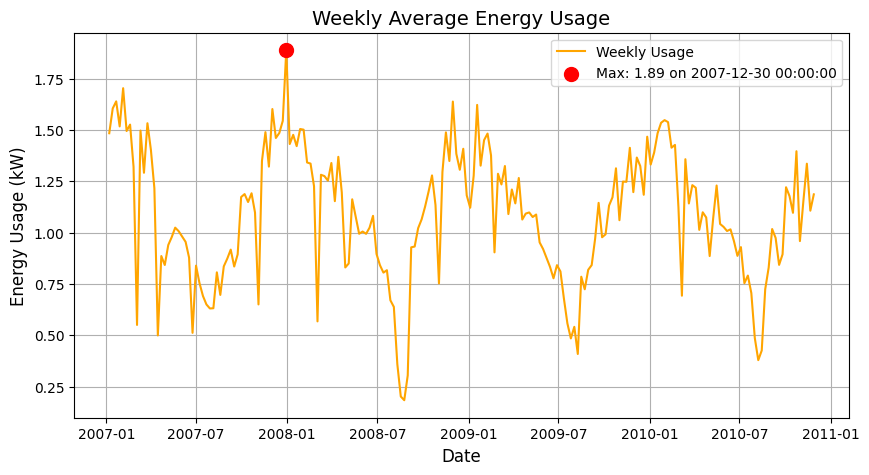

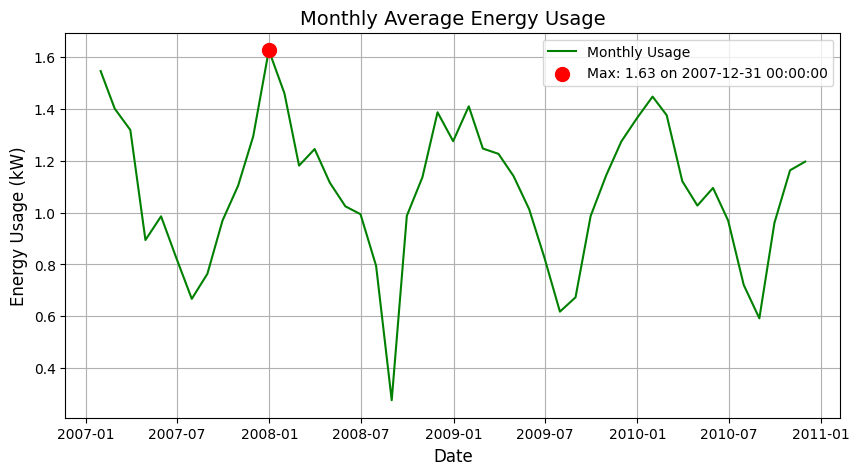

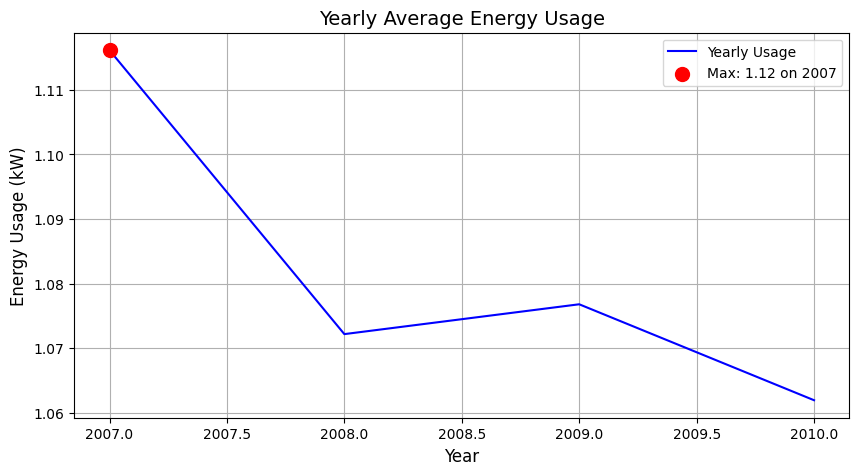

In [37]:
# Step 2: Display the data range
data_time_range = pd.DataFrame({'Start': [energy_data.index.min()], 'End': [energy_data.index.max()]})
print("\nEnergy Data Time Range:")  # Print the header for the data range
display(data_time_range.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Display the data range with borders

# Step 2.1: Filter data for the years 2007 to 2010
filtered_energy_data = energy_data[(energy_data.index.year >= 2007) & (energy_data.index.year <= 2010)]  # Filter data
filtered_energy_summary = pd.DataFrame({'Number of Records': [len(filtered_energy_data)]})  # Create summary
print("\nFiltered Energy Data (2007-2010):")  # Print the header for filtered data
display(filtered_energy_summary.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Display the filtered data summary with borders

# Step 3: Resample data to calculate averages
daily_energy_mean = filtered_energy_data['Global_active_power'].resample('D').mean()  # Daily averages
weekly_energy_mean = daily_energy_mean.resample('W').mean()  # Weekly averages
monthly_energy_mean = daily_energy_mean.resample('ME').mean()  # Monthly averages
yearly_energy_mean = daily_energy_mean.resample('YE').mean()  # Yearly averages
yearly_energy_mean.index = yearly_energy_mean.index.year  # Simplify the yearly index to just years

# Display resampled data
print("\nWeekly Average Energy Usage:")
display(weekly_energy_mean.to_frame(name="Weekly Average (kW)").style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Weekly data with borders
print("\nMonthly Average Energy Usage:")
display(monthly_energy_mean.to_frame(name="Monthly Average (kW)").style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Monthly data with borders
print("\nYearly Average Energy Usage:")
display(yearly_energy_mean.to_frame(name="Yearly Average (kW)").style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Yearly data with borders


# Step 4: Plot weekly, monthly, and yearly energy usage with max value highlighted
def plot_energy_usage_highlight_max(data, title, xlabel, ylabel, color, label):
    """
    Plot data and highlight the maximum value with a marker and label.
    """
    max_value = data.max()  # Find the maximum value in the data
    max_date = data.idxmax()  # Find the date corresponding to the maximum value
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(data.index, data, color=color, label=label)  # Line plot of the data
    plt.scatter(max_date, max_value, color='red', s=100, zorder=5, label=f"Max: {max_value:.2f} on {max_date}")  # Highlight max
    plt.title(title, fontsize=14)  # Set the plot title
    plt.xlabel(xlabel, fontsize=12)  # Set the x-axis label
    plt.ylabel(ylabel, fontsize=12)  # Set the y-axis label
    plt.legend()  # Add the legend
    plt.grid(True)  # Add gridlines
    plt.show()  # Show the plot

# Plot weekly, monthly, and yearly energy usage with maximum value highlighted
plot_energy_usage_highlight_max(weekly_energy_mean,
                                'Weekly Average Energy Usage',
                                'Date', 'Energy Usage (kW)',
                                'orange',
                                'Weekly Usage')
plot_energy_usage_highlight_max(monthly_energy_mean,
                                'Monthly Average Energy Usage',
                                'Date', 'Energy Usage (kW)',
                                'green',
                                'Monthly Usage')
plot_energy_usage_highlight_max(yearly_energy_mean, 'Yearly Average Energy Usage',
                                'Year',
                                'Energy Usage (kW)',
                                'blue',
                                'Yearly Usage')

### 3. Model Implementation :
This section evaluates the performance of Linear Regression, Random Forest, and XGBoost models on weekly, monthly, and yearly energy usage datasets. Key metrics (MAE, MSE, RMSE) are calculated and stored for comparison.

In [38]:
# Step 5: Model comparisons for Weekly, Monthly, and Yearly Usage
datasets = {
    "Weekly Energy Usage": (weekly_energy_mean.index.astype(int).values.reshape(-1, 1), weekly_energy_mean.values),
    "Monthly Energy Usage": (monthly_energy_mean.index.astype(int).values.reshape(-1, 1), monthly_energy_mean.values),
    "Yearly Energy Usage": (yearly_energy_mean.index.values.reshape(-1, 1), yearly_energy_mean.values),
}

# Dictionary to store metrics for each dataset
results = {}

# Iterate through datasets and evaluate models
for title, (X, y) in datasets.items():
    # Split the dataset into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    y_pred_linear = linear_model.predict(X_test)
    mae_linear = mean_absolute_error(y_test, y_pred_linear)
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    rmse_linear = np.sqrt(mse_linear)

    # Train a Random Forest Regression model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    mae_rf = mean_absolute_error(y_test, y_pred_rf)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    rmse_rf = np.sqrt(mse_rf)

    # Train an XGBoost Regression model
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)

    # Store metrics in a dictionary
    results[title] = pd.DataFrame({
        'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
        'MAE': [mae_linear, mae_rf, mae_xgb],
        'MSE': [mse_linear, mse_rf, mse_xgb],
        'RMSE': [rmse_linear, rmse_rf, rmse_xgb]
    })


### 4. Visualization of Model Performance Metrics and Result :
This section displays the evaluation metrics for each model (Linear Regression, Random Forest, XGBoost) across datasets. The results are visualized using bar charts for easier comparison of MAE, MSE, and RMSE values.



Weekly Energy Usage Model Comparison:


,Model,MAE,MSE,RMSE
0,Linear Regression,0.286007,0.122484,0.349977
1,Random Forest,0.133303,0.034759,0.186436
2,XGBoost,0.161280,0.052991,0.230198


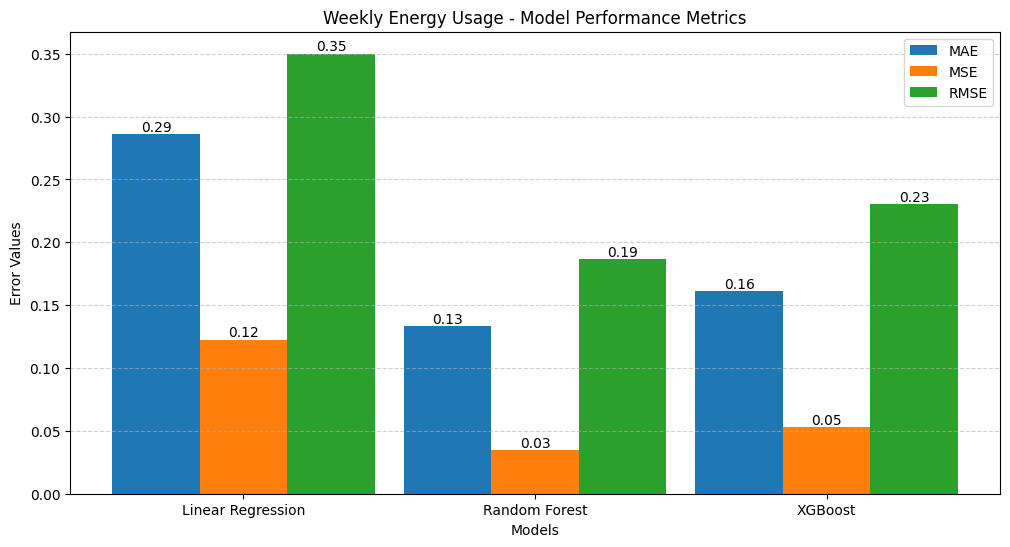


Monthly Energy Usage Model Comparison:


,Model,MAE,MSE,RMSE
0,Linear Regression,0.288575,0.132717,0.364304
1,Random Forest,0.194374,0.072155,0.268616
2,XGBoost,0.144126,0.038689,0.196695


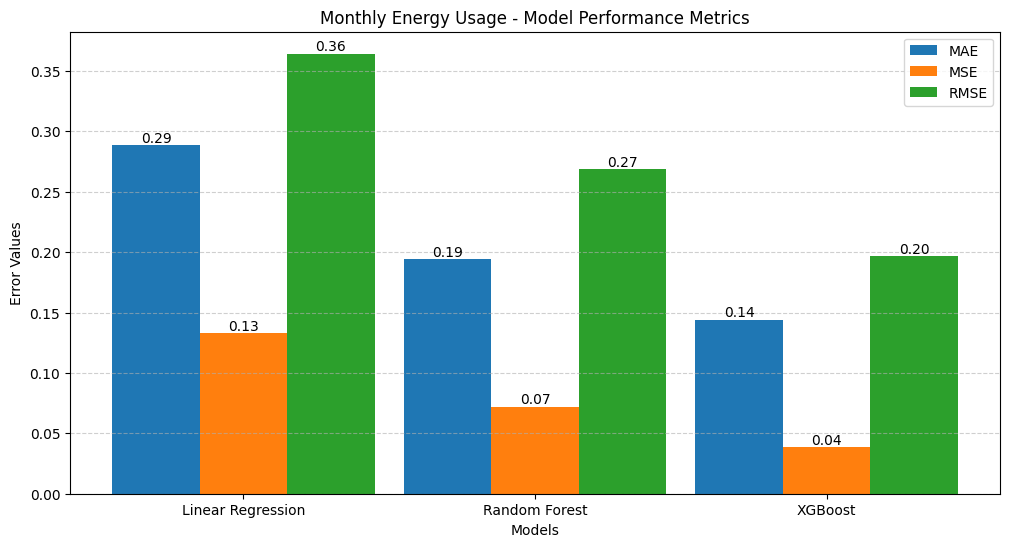


Yearly Energy Usage Model Comparison:


,Model,MAE,MSE,RMSE
0,Linear Regression,0.024982,0.000624,0.024982
1,Random Forest,0.030241,0.000915,0.030241
2,XGBoost,0.042924,0.001843,0.042924


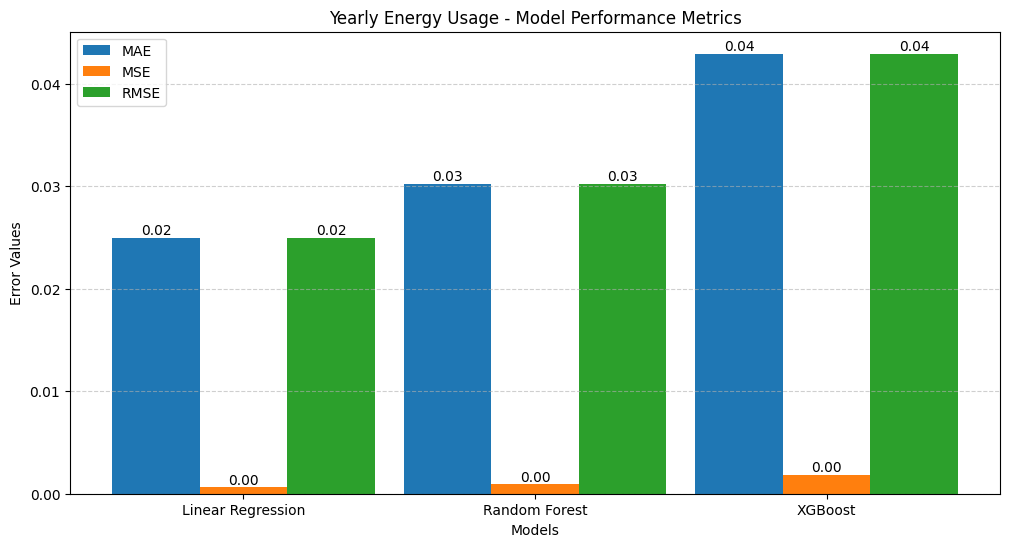

In [39]:
# Display and visualize results for each dataset
for title, metrics in results.items():
    print(f"\n{title} Model Comparison:")  # Print the title of the dataset
    display(metrics.style.set_table_styles(
        [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
    ))  # Display the metrics table with borders

    # Visualization of Model Performance Metrics
    plt.figure(figsize=(12, 6))  # Set the figure size
    x = np.arange(len(metrics['Model']))  # Model labels for x-axis
    width = 0.3  # Bar width

    # Plot the metrics as bar charts
    bars1 = plt.bar(x - width, metrics['MAE'], width, label='MAE')
    bars2 = plt.bar(x, metrics['MSE'], width, label='MSE')
    bars3 = plt.bar(x + width, metrics['RMSE'], width, label='RMSE')

    # Add numerical annotations above the bars
    for bar in bars1:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)
    for bar in bars2:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)
    for bar in bars3:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

    plt.xticks(x, metrics['Model'])  # Set x-axis labels
    plt.title(f'{title} - Model Performance Metrics')  # Add title to the plot
    plt.xlabel('Models')  # Label x-axis
    plt.ylabel('Error Values')  # Label y-axis
    plt.legend()  # Add legend to the plot
    plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add gridlines
    plt.show()  # Display the plot


### 5. Yearly Electricity Usage and Price Comparison :
This section combines yearly electricity usage and France's electricity prices to analyze trends. A dual-axis plot visualizes the relationship, showcasing energy usage and pricing over the years for comparison.


Yearly Energy Usage and Price Comparison:


,Yearly Avg Energy Usage (kW),Electricity Price (€/MWh)
2007,1.116143,7.812616
2008,1.072174,8.967951
2009,1.076795,10.210607
2010,1.061935,10.700674


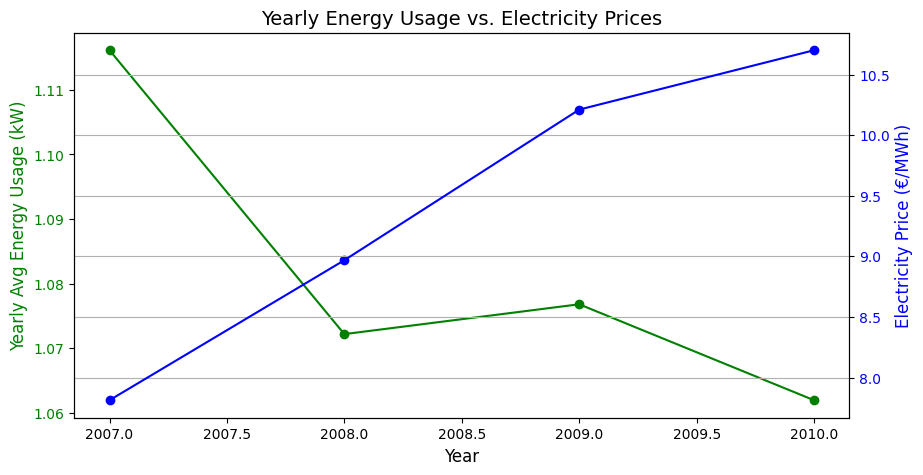

In [40]:
# Step 6: Yearly Electricity Usage and Price Comparison
# Load the electricity price dataset
price_filepath = '/content/drive/MyDrive/Final Project/Domestic electricity prices in the IEA.xlsx'  # Filepath for price data
electricity_prices = pd.read_excel(price_filepath)  # Load the Excel file into a DataFrame

# Extract France-specific electricity prices and format the data
france_electricity_prices = electricity_prices[electricity_prices['Country'] == 'France'].iloc[:, 1:].T  # Extract relevant rows
france_electricity_prices.columns = ['Electricity Price (€/MWh)']  # Rename column for clarity
france_electricity_prices.index = france_electricity_prices.index.astype(int)  # Convert year index to integers

# Combine yearly energy usage and electricity price data
yearly_comparison = pd.DataFrame({
    'Yearly Avg Energy Usage (kW)': yearly_energy_mean,  # Add yearly energy usage
    'Electricity Price (€/MWh)': france_electricity_prices.squeeze()  # Add electricity price data
}).dropna()  # Remove rows with missing values

# Display the combined data
print("\nYearly Energy Usage and Price Comparison:")
display(yearly_comparison.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '5px')]}]
))  # Display the table with borders

# Plot yearly energy usage and electricity price trends with annotations
fig, ax1 = plt.subplots(figsize=(10, 5))  # Create a figure with one axis
ax2 = ax1.twinx()  # Create a secondary y-axis

# Plot yearly energy usage on the primary axis
ax1.plot(yearly_comparison.index, yearly_comparison['Yearly Avg Energy Usage (kW)'],
         'g-', label='Yearly Avg Energy Usage')  # Line plot for energy usage
ax1.scatter(yearly_comparison.index, yearly_comparison['Yearly Avg Energy Usage (kW)'],
            color='green', label='Energy Usage Points')  # Scatter plot for points

# Plot electricity prices on the secondary axis
ax2.plot(yearly_comparison.index, yearly_comparison['Electricity Price (€/MWh)'],
         'b-', label='Electricity Price')  # Line plot for electricity prices
ax2.scatter(yearly_comparison.index, yearly_comparison['Electricity Price (€/MWh)'],
            color='blue', label='Price Points')  # Scatter plot for points

# Add labels, title, and legend
ax1.set_xlabel('Year', fontsize=12)  # Label x-axis
ax1.set_ylabel('Yearly Avg Energy Usage (kW)', color='g', fontsize=12)  # Label left y-axis
ax2.set_ylabel('Electricity Price (€/MWh)', color='b', fontsize=12)  # Label right y-axis
ax1.tick_params(axis='y', labelcolor='g')  # Customize tick color for left y-axis
ax2.tick_params(axis='y', labelcolor='b')  # Customize tick color for right y-axis
plt.title('Yearly Energy Usage vs. Electricity Prices', fontsize=14)  # Add title
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot